In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint
import cvxpy as cp
import numpy as np
import itertools

In [128]:
df = pd.read_csv('/Users/thomasdeconinck/Downloads/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1108:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

df_10 = df.iloc[1049:1169]
ret = df_5.values / 100
variance = np.var(ret, axis=0, keepdims=True)
std = np.sqrt(np.var(ret, axis=0, keepdims=True))

# Plage des rendements cibles
target_returns = np.linspace(-0.10, 0.10, num=100)  # Génère 100 valeurs entre -10% et 10%

rf = 0.44 / 100

# Créer la liste portfolio_names à partir des noms de colonnes, en excluant la première colonne
portfolio_names = df.columns[1:].tolist()

# Définissons la matrice de covariance et le vecteur de rendements moyens
Sigma = np.cov(ret.T)

z_barre = np.mean(ret, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
ones = np.ones((len(Z_barre))) # Vecteur de 1

# Rendement espéré du portefeuille cible
R_cible = 0.10  # Rendement espéré du portefeuille cible


In [129]:
N = 5  # Nombre total d'actifs
min_num_assets = 3
max_num_assets = 3
min_weight = 0.05  # poids minimum de 5%
target_return = 0.10 

### Borne de rendement cible obligatoire pour le portefeuille car sinon lorsque la contrainte est implementé : Brut force approach inefficient

In [130]:
R_cible_basse = 0.01  # Rendement cible minimum de 5%
R_cible_haute = 0.10  # Rendement cible maximum de 15%

In [131]:
# Fonction objectif : Variance du portefeuille
def portfolio_variance(W,Sigma):
    return W.T @ (Sigma @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return})  # Le rendement attendu doit être égal au rendement cible

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(portfolio_variance, W, Sigma, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

Poids optimaux du portefeuille : [-9.63824634  1.83034021 15.7856131  -3.96809386 -3.00961311]


/Users/thomasdeconinck/anaconda3/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [132]:
from scipy.optimize import minimize
import numpy as np
from itertools import combinations

# Résultats initiaux
best_variance = np.inf
best_weights = None
best_combination = None

# Générer toutes les combinaisons de 3 portefeuilles parmi 5
for combination in combinations(range(N), 3):
    Sigma_sub = Sigma[np.ix_(combination, combination)]
    Z_barre_sub = Z_barre[np.array(combination)]  # Assurez-vous que Z_barre_sub est correctement défini

    initial_weights = np.ones(len(combination)) / len(combination)

    # Définissez les contraintes en utilisant Z_barre_sub
    current_constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Les poids doivent sommer à 1
        {'type': 'ineq', 'fun': lambda weights: np.dot(weights, Z_barre_sub) - R_cible_basse},
        {'type': 'ineq', 'fun': lambda weights: R_cible_haute - np.dot(weights, Z_barre_sub)}  # Utilisez np.dot ici pour la compatibilité dimensionnelle
    ]

    # Lancer l'optimisation avec Sigma_sub et Z_barre_sub
    result = minimize(portfolio_variance, initial_weights, args=(Sigma_sub,), method='trust-constr', constraints=current_constraints)

    if result.success and result.fun < best_variance:
        best_variance = result.fun
        best_weights = result.x
        best_combination = [portfolio_names[i] for i in combination]  # Mappage des indices aux noms de portefeuilles

# Affichage des résultats
if best_combination is not None:
    print("Meilleure combinaison d'actifs:", best_combination)
    print("Poids optimaux:", best_weights)
    print("Variance minimale du portefeuille:", best_variance)

Meilleure combinaison d'actifs: ['HiTec', 'Hlth ', 'Other']
Poids optimaux: [ 0.36663047  0.75562884 -0.12225931]
Variance minimale du portefeuille: 0.0023281872903007515


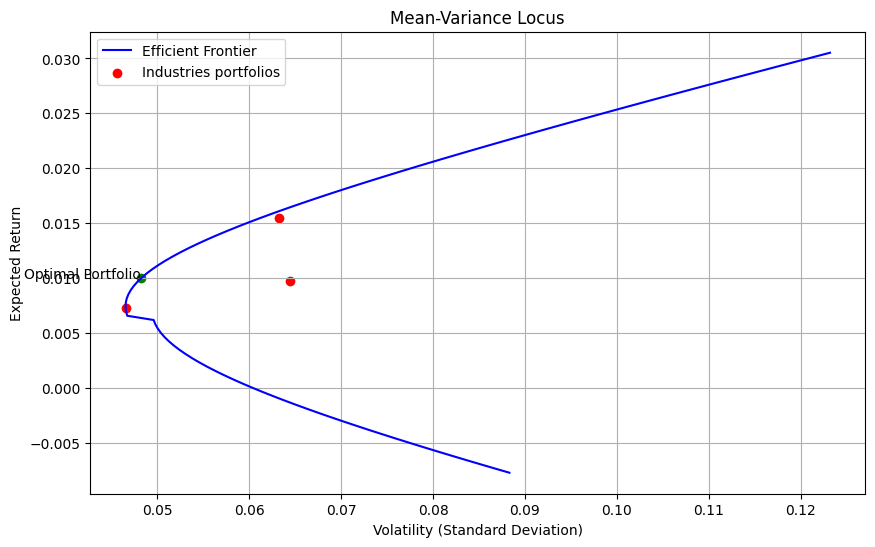

In [133]:
# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100) 

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []
for R_cible in rendements_cibles:
    current_constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, Z_barre_sub) - R_cible}
    ]
    result = minimize(portfolio_variance, initial_weights, args=(Sigma_sub,), method='SLSQP', constraints=current_constraints)
    if result.success:
        rendement_optimal = np.dot(result.x, Z_barre_sub)
        volatilite_optimale = np.sqrt(result.fun)
        rendements_optimaux.append(rendement_optimal)
        volatilites_optimales.append(volatilite_optimale)

# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Efficient Frontier')
plt.scatter(np.sqrt(np.diag(Sigma_sub)), Z_barre_sub, color='red', label='Industries portfolios')
# Tracer le portefeuille optimal

plt.title('Mean-Variance Locus')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)

# Calculer le rendement et la volatilité du portefeuille optimal selon la combinaison optimale de 3 actifs parmi 5 actifs disponibles 
rendement_optimal = np.dot(best_weights, Z_barre_sub)
volatilite_optimale = np.sqrt(np.dot(best_weights.T, np.dot(Sigma_sub, best_weights)))

# Tracer le portefeuille optimal
plt.scatter(volatilite_optimale, rendement_optimal, color='green', label='Optimal Portfolio')
plt.text(volatilite_optimale, rendement_optimal, 'Optimal Portfolio', ha='right')
plt.show()

In [191]:
data = pd.read_csv('48_Industry_Portfolios.CSV', skiprows=range(1, 11), nrows=1181-11, na_values=['-99.99', '-999'])
data = data.iloc[:1181]

data = data.rename(columns={data.columns[0]: 'Date'})
# Remplacer les valeurs '-99.99' et '-999' par NaN
data = data.replace(['-99.99', '-999'], pd.NA)

data = data.apply(pd.to_numeric, errors='coerce')
data

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Date
NaN,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,Hlth,MedEq,Drugs,Chems,Rubbr,Txtls,BldMt,Cnstr,Steel,FabPr,Mach,ElcEq,Autos,Aero,Ships,Guns,Gold,Mines,Coal,Oil,Util,Telcm,PerSv,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,NaN
192607.0,2.37,0.12,-99.99,-5.19,1.29,8.65,2.50,50.21,-0.48,8.08,-99.99,4.95,0.91,8.14,-99.99,0.39,2.46,-8.21,4.07,-99.99,5.43,3.18,16.39,-0.65,1.05,-99.99,-99.99,5.64,1.54,-1.40,7.04,0.83,-99.99,5.85,3.76,1.31,1.35,-99.99,7.70,1.92,-23.79,0.07,1.87,4.61,-0.54,2.89,-5.77,5.20
192608.0,2.23,2.68,-99.99,27.03,6.50,16.81,-0.76,42.98,-3.58,-2.51,-99.99,4.20,4.26,5.50,-99.99,7.97,4.63,7.37,2.17,-99.99,2.06,2.10,4.23,-6.58,1.80,-99.99,-99.99,0.55,0.85,3.69,-1.69,2.17,-99.99,1.51,3.57,-4.70,6.89,-99.99,-2.38,4.85,5.39,-0.75,-0.13,11.83,2.57,5.30,0.32,6.76
192609.0,-0.57,1.58,-99.99,4.02,1.26,8.33,6.42,-4.91,0.73,-0.51,-99.99,4.02,-0.26,5.33,-99.99,2.30,-0.11,-11.76,0.15,-99.99,0.36,-0.56,4.83,-7.09,2.88,-99.99,-99.99,1.74,0.30,-3.69,2.04,2.41,-99.99,0.81,4.23,-6.04,-0.63,-99.99,-5.54,0.08,-7.87,0.25,-0.56,-1.75,0.72,-3.06,-4.81,-3.86
192610.0,-0.46,-3.68,-99.99,-3.31,1.06,-1.40,-5.09,5.37,-4.68,0.12,-99.99,3.47,-1.76,-4.76,-99.99,1.00,-4.42,-8.59,-3.85,-99.99,1.11,-5.73,-7.93,-13.36,-5.45,-99.99,-99.99,-3.20,2.23,-1.04,-2.63,-0.11,-99.99,1.81,-2.47,-3.92,0.21,-99.99,-5.08,-2.62,-15.38,-2.20,-4.11,-11.82,-4.28,-5.74,-0.94,-8.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202307.0,-0.95,2.10,2.15,3.24,1.49,6.99,1.30,3.94,0.33,1.01,-0.34,-2.18,0.67,4.31,1.98,3.46,3.65,3.65,3.41,10.55,6.09,3.85,2.87,1.76,5.26,-2.38,2.05,9.42,8.70,7.32,2.79,0.98,4.12,4.69,2.72,3.59,3.27,5.01,5.55,7.09,-1.03,3.21,2.87,7.14,3.88,5.26,8.22,1.46
202308.0,-8.39,-5.31,-1.34,-4.62,-3.28,-0.90,-4.40,5.87,-1.75,-6.04,-4.34,-6.96,2.61,-4.15,3.60,-3.92,-0.60,-1.77,-1.57,-0.44,-1.75,-8.53,-4.79,-2.37,-5.57,2.01,-9.87,-5.56,3.36,1.99,-5.29,0.14,-2.51,-1.60,3.14,-2.48,-0.06,-1.60,-3.67,-6.63,-1.54,0.48,-5.12,-5.08,-1.87,-4.76,-2.49,0.41
202309.0,0.84,-4.28,-6.43,-5.13,-2.43,-7.38,-11.17,-6.19,-6.81,-4.41,-5.26,-6.90,-3.95,-6.22,-7.75,-11.92,-7.42,-9.34,-4.58,-6.14,-6.65,-7.44,-2.41,-10.61,-5.45,-8.52,-5.77,-7.02,25.88,3.02,-5.04,-3.22,-4.92,-4.38,-4.38,-8.37,-7.35,-6.54,-2.57,-5.15,-2.69,-6.16,-4.45,-3.92,2.57,-10.45,-3.49,-2.72
202310.0,-5.83,-4.98,-0.39,-4.34,-4.00,-14.31,2.77,-2.05,-0.05,4.21,-4.31,-6.20,-4.11,-6.49,-10.23,-6.24,-6.65,-5.84,-4.01,-26.00,-6.92,-12.69,-18.32,3.76,-0.49,9.36,1.82,-5.36,-10.10,-6.23,1.12,-0.18,-1.98,-0.48,-0.49,-2.88,-10.89,-2.70,-3.46,-6.31,-0.90,0.74,-1.71,-2.89,3.49,-9.05,-6.31,-1.77
